# ZUM Praca domowa

PJATK ZUM Praca domowa

Dane: plik CSV, język polski, opinie pacjentów dotyczące wizyty w szpitalu/klinice lub innych o tematyce medycznej. Na końcu zdania dodane są odpowiednie etykiety:

    __label__z_minus_m - negatywne
    __label__z_zero - neutralne
    __label__z_amb - niejednoznaczne
    __label__z_plus_m - pozytywne

Na potrzeby tego projektu zdania z etykietą zero i amb zostają pominięte
Źródło danych: https://clarin-pl.eu/dspace/handle/11321/710 -> tylko plik medicine.sentence.train

Modele: LSTM, CNN, pre-trained word embedding, DistilBert

Plik sentiment-medical-pl-utf.csv zawiera dane treningowe

Na końcu umieściłem funkcję z możliwością napisania własnego zdania z wynikiem Positive/Negative, przez problemy z zasobami na Colabie musiałem jednak wykomentować model z word embeddingiem oraz DistilBert

# Obsługa pliku CSV



Plik CSV pobrany z GitHuba wystarczy wrzucić do najwyższego poziomu dysku Google, zachowując orginalną nazwę pliku.

# LSTM

In [47]:
import pandas as pd
import numpy as np

import torch
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
import tensorflow as tf
from tensorflow import keras
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import pickle

In [48]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
names = ['Text']
data = pd.read_csv('/content/drive/MyDrive/sentiment-medical-pl-utf.csv', on_bad_lines='skip', delimiter='\t', names=names)

def process_line(line):
    sentence, label = line.rsplit('__label__', 1)
    sentence = sentence.strip()
    label = label.strip()

    if label == 'z_plus_m':
      label_value = 1
    elif label == 'z_minus_m':
      label_value = 0
    else:
      label_value = None
      sentence = None

    return sentence, label_value

def convert_csv(input_file, output_file):
    df = pd.read_csv('/content/drive/MyDrive/sentiment-medical-pl-utf.csv', on_bad_lines='skip', delimiter='\t', names=names)

    df[['Sentence', 'Label']] = df['Text'].apply(lambda x: pd.Series(process_line(x)))

    df = df.drop('Text', axis=1)

    df.to_csv(output_file, index=False)

input_csv_file = '/content/drive/MyDrive/sentiment-medical-pl-utf.csv'
output_csv_file = 'output.csv'

convert_csv(input_csv_file, output_csv_file)

df = pd.read_csv(output_csv_file)

df = df.dropna()

#split
train_data, test_data, train_labels, test_labels = train_test_split(
    df['Sentence'], df['Label'], test_size=0.2, random_state=42
)

In [50]:
df.shape

(9866, 2)

<Axes: xlabel='Label', ylabel='count'>

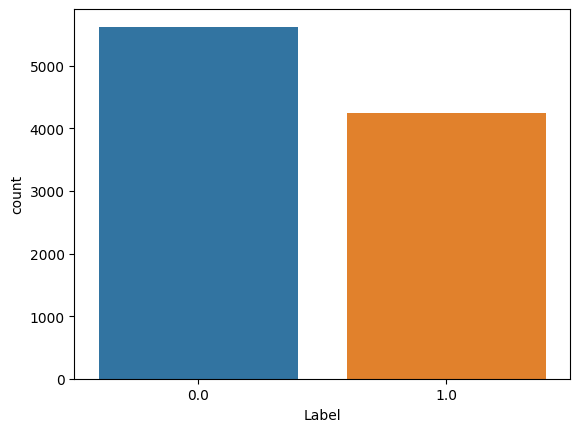

In [51]:
sns.countplot(x='Label', data=df)

In [52]:
#examples of each class
#positive
df[df['Label']==1].sample(15)

,Sentence,Label
8059,Do każdego pacjenta podchodzi z wyjątkowym zaa...,1.0
3929,"Jego podejście zarówno do małych pacjentów , j...",1.0
6250,Wyraził chęć pomocy również po hospitalizacji ...,1.0
12768,A leczenie i rehabilitacja ( sugestie dotycząc...,1.0
2798,"Jak był problem z realizacją recepty , szybko ...",1.0
17822,Cechuje się Pani wielkim oddaniem dla swoich p...,1.0
10537,Zawsze bardzo dokładnie i z ogromną starannośc...,1.0
2434,I tu wielkie zaskoczenie .,1.0
16651,"Serdecznie polecam i każdemu , kto zacznie życ...",1.0
12983,Badanie jest bardzo dokładne .,1.0


In [53]:
#examples of each class
#negative
df[df['Label']==0].sample(15)

,Sentence,Label
14204,Nie polecam rodzicom którym zależy na tym aby ...,0.0
1360,Oceniam lekarza bardzo słabo .,0.0
14573,Operacja skończyła się ostrym zapaleniem otrze...,0.0
4922,Na NFZ internista więcej pomoże niż on .,0.0
6401,"Poprosił żeby m wyszczerzyla zeby , po czym pr...",0.0
9598,"Przez kilka miesięcy cieszyła m się , ze syn p...",0.0
304,Niestety lekarz szybko i mało profesjonalnie (...,0.0
8291,Osobiście nie polecam a wręcz odradzam szczegó...,0.0
3935,"Dodam , że na dzień dzisiejszy zmagam się z no...",0.0
10090,Siedzieli sobie trzej panowie w gabinecie ( do...,0.0


In [54]:
max_words = 10000
max_len = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [55]:
embedding_dim = 64

modelLSTM = Sequential()
modelLSTM.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
modelLSTM.add(LSTM(units=100))
modelLSTM.add(Dense(1, activation='sigmoid'))

modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
epochs = 5
batch_size = 64

modelLSTM.fit(train_sequences_padded, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

modelLSTM.save('lstm_model.h5')

with open('tokenizerLSTM.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

Epoch 1/5
99/99 [==============================] - 11s 88ms/step - loss: 0.6111 - accuracy: 0.6634 - val_loss: 0.4833 - val_accuracy: 0.7796
Epoch 2/5
99/99 [==============================] - 11s 110ms/step - loss: 0.3322 - accuracy: 0.8701 - val_loss: 0.4121 - val_accuracy: 0.8138
Epoch 3/5
99/99 [==============================] - 6s 56ms/step - loss: 0.2213 - accuracy: 0.9172 - val_loss: 0.4508 - val_accuracy: 0.8062
Epoch 4/5
99/99 [==============================] - 4s 41ms/step - loss: 0.1352 - accuracy: 0.9571 - val_loss: 0.5412 - val_accuracy: 0.8011
Epoch 5/5
99/99 [==============================] - 4s 36ms/step - loss: 0.0711 - accuracy: 0.9788 - val_loss: 0.6196 - val_accuracy: 0.7929


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
loss, accuracy = modelLSTM.evaluate(test_sequences_padded, test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

62/62 [==============================] - 0s 5ms/step - loss: 0.6179 - accuracy: 0.7999
Test Loss: 0.6178972721099854, Test Accuracy: 0.7998986840248108


# CNN

In [75]:
max_words = 10000
max_len = 128

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)


embedding_dim = 64
filter_sizes = [3, 4, 5]
num_filters = 128

modelCNN = Sequential()
modelCNN.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

for filter_size in filter_sizes:
    modelCNN.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))

modelCNN.add(GlobalMaxPooling1D())
modelCNN.add(Dense(1, activation='sigmoid'))

modelCNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 5
batch_size = 64

modelCNN.fit(train_sequences_padded, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

modelCNN.save('cnn_model.h5')

with open('tokenizerCNN.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

loss, accuracy = modelCNN.evaluate(test_sequences_padded, test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/5
99/99 [==============================] - 13s 101ms/step - loss: 0.6045 - accuracy: 0.6617 - val_loss: 0.4807 - val_accuracy: 0.7669
Epoch 2/5
99/99 [==============================] - 6s 64ms/step - loss: 0.3255 - accuracy: 0.8600 - val_loss: 0.4222 - val_accuracy: 0.8151
Epoch 3/5
99/99 [==============================] - 4s 37ms/step - loss: 0.1445 - accuracy: 0.9461 - val_loss: 0.5489 - val_accuracy: 0.8087
Epoch 4/5
99/99 [==============================] - 2s 24ms/step - loss: 0.0606 - accuracy: 0.9769 - val_loss: 0.6468 - val_accuracy: 0.7872
Epoch 5/5
99/99 [==============================] - 2s 22ms/step - loss: 0.0287 - accuracy: 0.9900 - val_loss: 0.9576 - val_accuracy: 0.7885


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 1s 5ms/step - loss: 0.9321 - accuracy: 0.7842
Test Loss: 0.9320680499076843, Test Accuracy: 0.7841945290565491


# Pre-trained word embedding

In [59]:
# #pre-trained word embeddings
# !pip install -U fasttext
# import fasttext.util
# import fasttext
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [60]:
# names = ['Text']
# data = pd.read_csv('/content/drive/MyDrive/zum_praca_domowa/sentiment-medical-pl-utf.csv', on_bad_lines='skip', delimiter='\t', names=names)

# def process_line(line):
#     sentence, label = line.rsplit('__label__', 1)
#     sentence = sentence.strip()
#     label = label.strip()

#     if label == 'z_plus_m':
#       label_value = 1
#     elif label == 'z_minus_m':
#       label_value = 0
#     else:
#       label_value = None
#       sentence = None

#     return sentence, label_value

# def convert_csv(input_file, output_file):
#     df = pd.read_csv('/content/drive/MyDrive/zum_praca_domowa/sentiment-medical-pl-utf.csv', on_bad_lines='skip', delimiter='\t', names=names)

#     df[['Sentence', 'Label']] = df['Text'].apply(lambda x: pd.Series(process_line(x)))

#     df = df.drop('Text', axis=1)

#     df.to_csv(output_file, index=False)

# input_csv_file = '/content/drive/MyDrive/zum_praca_domowa/sentiment-medical-pl-utf.csv'
# output_csv_file = '/content/drive/MyDrive/zum_praca_domowa/output.csv'

# convert_csv(input_csv_file, output_csv_file)

# df = pd.read_csv(output_csv_file)

# df = df.dropna()

# #split
# train_data, test_data, train_labels, test_labels = train_test_split(
#     df['Sentence'], df['Label'], test_size=0.2, random_state=42
# )

In [61]:
# # Download and load FastText embeddings for Polish
# fasttext.util.download_model('pl', if_exists='ignore')
# ft = fasttext.load_model('cc.pl.300.bin')

In [62]:
# max_words = 10000
# max_len = 100

# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(train_data)

# train_sequences = tokenizer.texts_to_sequences(train_data)
# test_sequences = tokenizer.texts_to_sequences(test_data)

# train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len)
# test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [63]:
# embedding_dim = 300
# word_index = tokenizer.word_index
# num_words = min(max_words, len(word_index) + 1)
# embedding_matrix = np.zeros((num_words, embedding_dim))

In [64]:
# for word, i in word_index.items():
#     if i < max_words and word in ft.words:
#         embedding_matrix[i] = ft[word]

# modelEMB = Sequential()
# modelEMB.add(Embedding(
#     input_dim=num_words,
#     output_dim=embedding_dim,
#     weights=[embedding_matrix],
#     input_length=max_len,
#     trainable=False
# ))
# modelEMB.add(Conv1D(filters=100, kernel_size=3, activation='relu'))
# modelEMB.add(GlobalMaxPooling1D())
# modelEMB.add(Dense(1, activation='sigmoid'))

# modelEMB.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# epochs = 5
# batch_size = 64

# modelEMB.fit(train_sequences_padded, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# modelEMB.save('emb_model.h5')

# loss, accuracy = modelEMB.evaluate(test_sequences_padded, test_labels)
# print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Fine tuning

In [65]:
#fine-tuning

In [66]:
# label_encoder = LabelEncoder()
# df['Label'] = label_encoder.fit_transform(df['Label'])

# train_data, test_data, train_labels, test_labels = train_test_split(
#     df['Sentence'], df['Label'], test_size=0.2, random_state=42
# )

# tokenizerTUN = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# train_encodings = tokenizerTUN(train_data.tolist(), truncation=True, padding=True)
# test_encodings = tokenizerTUN(test_data.tolist(), truncation=True, padding=True)

# train_dataset = TensorDataset(
#     torch.tensor(train_encodings['input_ids']),
#     torch.tensor(train_encodings['attention_mask']),
#     torch.tensor(train_labels.values)
# )

# test_dataset = TensorDataset(
#     torch.tensor(test_encodings['input_ids']),
#     torch.tensor(test_encodings['attention_mask']),
#     torch.tensor(test_labels.values)
# )

In [67]:
# modelTUN = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

# batch_size = 64
# epochs = 1
# optimizer = AdamW(modelTUN.parameters(), lr=2e-5)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# modelTUN.to(device)

# for epoch in range(epochs):
#     modelTUN.train()
#     total_loss = 0
#     for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
#         input_ids, attention_mask, labels = batch
#         input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = modelTUN(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     average_loss = total_loss / len(train_loader)
#     print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {average_loss}')

# modelTUN.eval()
# total_correct = 0

# with torch.no_grad():
#     for batch in tqdm(test_loader, desc='Evaluating'):
#         input_ids, attention_mask, labels = batch
#         input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#         outputs = modelTUN(input_ids, attention_mask=attention_mask)
#         logits = outputs.logits
#         predictions = torch.argmax(logits, dim=1)
#         total_correct += torch.sum(predictions == labels).item()

# modelTUN.save_pretrained('tun_model.h5')

# accuracy = total_correct / len(test_loader.dataset)
# print(f'Test Accuracy: {accuracy}')

# Custom sentence and setting model

In [85]:
def load_tokenizer_and_model(model_name):
    if model_name.lower() == 'lstm':
            with open('tokenizerLSTM.pkl', 'rb') as handle:
              tokenizer = pickle.load(handle)
              model = tf.keras.models.load_model('lstm_model.h5')
    elif model_name.lower() == 'cnn':
        with open('tokenizerCNN.pkl', 'rb') as handle:
              tokenizer = pickle.load(handle)
              model = tf.keras.models.load_model('cnn_model.h5')
    else:
        raise ValueError("Incorrect model name. Set models: 'lstm' or 'cnn'")

    return tokenizer, model

def predict_sentiment(model_name, sentence):
    tokenizer, model = load_tokenizer_and_model(model_name)

    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=128)

    predictions = model.predict(padded_sequence)

    sentiment_label = 'Positive' if predictions[0][0] > 0.5 else 'Negative'

    return sentiment_label

# Models to set:
model_name = 'lstm'  #'lstm' or 'cnn'

#Examples to test
#sentence_to_predict = "Pierwsza wizyta miła, można powiedzieć, że kontrolna, ponieważ chciałam zrobić cytologie i skonsultować coś co mnie niepokoiło."
#sentence_to_predict = "Zgadzam się z opiniami o naciąganiu na niepotrzebne badania, a nawet podejrzewam, że mogło u niego dochodzić do fałszowania wyników badań."
#sentence_to_predict = "to jest tragicznie wykonana praca domowa, nie może być uznana za dostateczną"
sentence_to_predict = "to jest doskonale wykonana praca domowa, nie ma zadnych błędów"

prediction = predict_sentiment(model_name, sentence_to_predict)
print(f"The sentiment prediction for the given sentence is: {prediction}")

1/1 [==============================] - 0s 333ms/step
The sentiment prediction for the given sentence is: Positive
